# Generating Dispersion Diagrams with FenicsX

Josh Tempelman

University of Illinois at Urbana Champaign

jrt7@illinois.edu


### About:

This script shows how to use the functions from the `FEM_Functions`, `PostProcess`, and `MeshFunctions` modules. This is a part of the software 'fenonics'. 

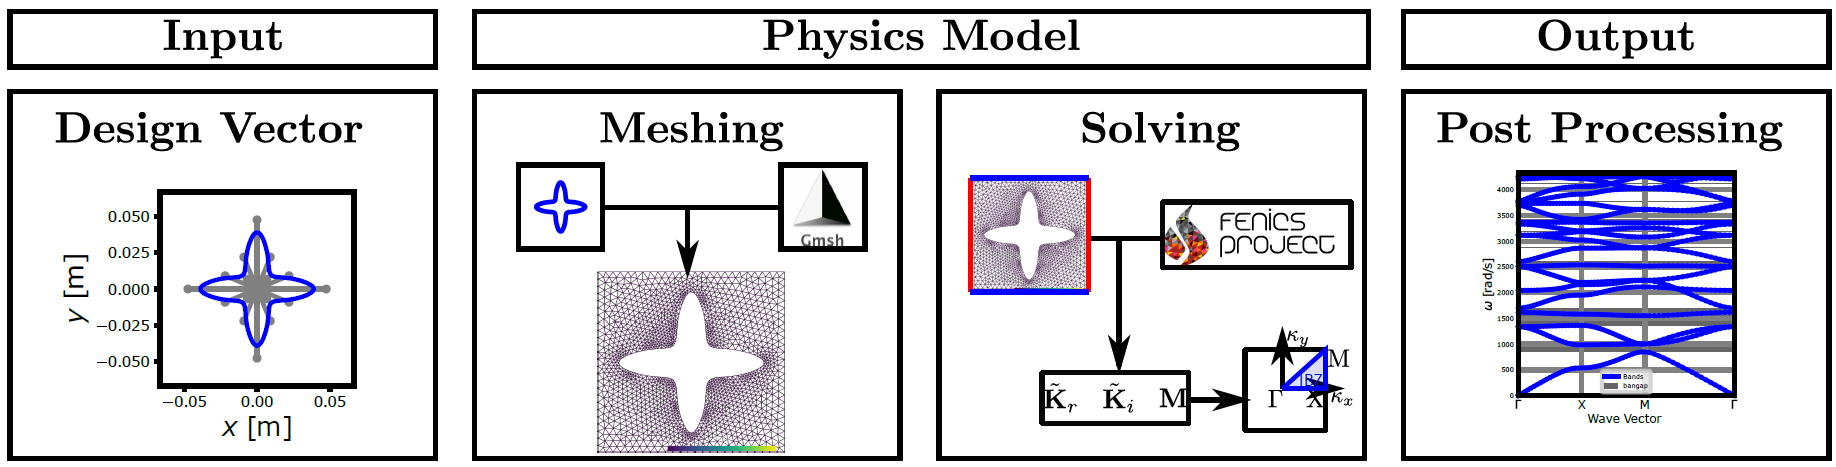

In [1]:
# ################################################## #
# Genearal imports                                   #
# ################################################## #
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# ################################################## #
# Imports for the meshing                            #
# ################################################## #
from dolfinx.io.gmshio  import model_to_mesh
import gmsh

# ################################################## #
# Fenonic Imports                                    #
# ################################################## #
from FEM_Functions import *
from PostProcess import*
from MeshFunctions import get_mesh_SquareSpline 



## Part 1: Generating a mesh

We start by defining some parameters for the void in our square unit cell


    a_len   -            Charecterstic unit cell length (primitive basis)

    r        -           vector of points to fit spline to

    Nquads    -          Number of quadrants to repeat spline through (radially)
    
    offset     -         Offset angle for inclusion geometry

    iscut       -        Choose if inclusion is void or an filled
    
    da      -           Nominal distance between nodes

    refinement_level -   Choose how much denser mesh gets around refinement field

    refinement_dist  -   Maximum distance of refinement field from refined edges
    
    isrefined        -   Choose whether or not to refine mesh around internal edges

    meshalg          -   Meshing algorithm for gmsh to use

Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
 --------- ERROR HERE --------------
Info    : Error in transformation from curve 2 (52-50) to 4 (53-52) (minimal transformed node distances 0 0.141421, tolerance 1.45633e-09)
Info    : Error in transformation from curve 3 (51-53) to 1 (50-51) (minimal transformed node distances 0.223607 0.1, tolerance 1.45633e-09)
 --------- ERROR HERE --------------
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.171606s, CPU 0.172467s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0312927s, CPU 0.032268s)
to here
Info    : 1785 nodes 3530 elements


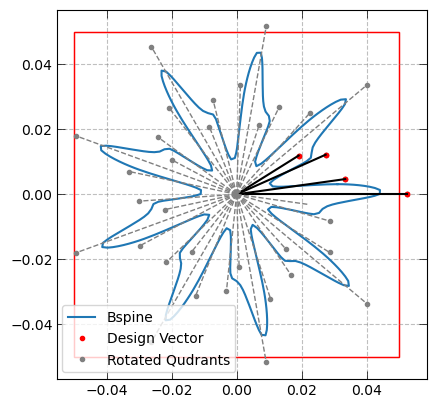


No module named 'trame'

Falling back to a static output.
  warnings.warn(



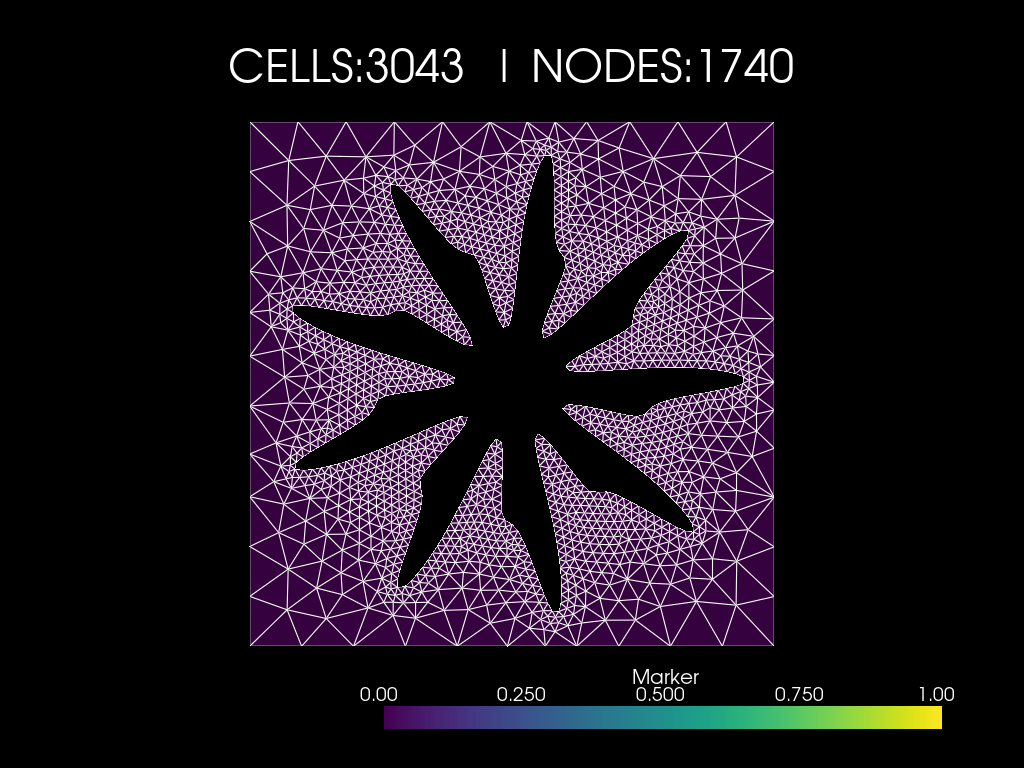

In [14]:
# Meshing parameters
cut         = True
a_len       = .1
r           = np.array([1.4,.9,0,.8,.6])*a_len*.75
offset      = 0*np.pi/4
design_vec  = np.concatenate( (r/a_len, [offset] ))
Nquads      = 9
da                  =   a_len/10
refinement_level    =   6
refinement_dist     =   a_len/10
meshalg                 = 6

# Make the mesh with Gmsh
gmsh.model, xpt, ypt    = get_mesh_SquareSpline(
        a_len, da, r, Nquads, offset, meshalg,
        refinement_level, refinement_dist,
        isrefined = True,   cut = cut
)

# Import to dolfinx               
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)

# Plot the design vector and the produced mesh
plt = PlotSpline(gmsh, r, Nquads, a_len, xpt, ypt)
plt.show()
plotmesh(mesh,ct)

Now we convert the gmsh object to a dolfinx mesh. The `model_to_mesh` module returns the mesh in the correct format along with `ct` which account for domain tags constructed in `gmsh`. Thses tags will be needed if assigneing material propeties to multiple domains

Now we set up the physical problem. The quanties are $c$ and $\rho$, for the equation

$$
c^2\nabla u(x,t) - \frac{\partial^2}{\partial t^2}u(x,t) = 0
$$

If the inclusion gemoetry is not a cut out, then ehere are two domains in the unit cell that both need ot be. We also set np1, np2, and np3, which are the number of poitns we visit in k space between the high symmetry points $\Gamma$-$X$-$M$-$\Gamma$

In [15]:
if not cut:
    c           = [1500,5100]   # if solid inclusion (mutlple materail model)
    rho         = [1e3,7e3]     # if solid inclusion (mutlple materail model) 
else:
    c           = [30]          # if void inclusion  (if iscut)
    rho         = [1.2]         # if void inclusion  (if iscut)

Now we solve the entire band structure using the finite-element method. The following code solves the eigenproblem along  the $\Gamma$-X-M-$\Gamma$ boundary of the IBZ
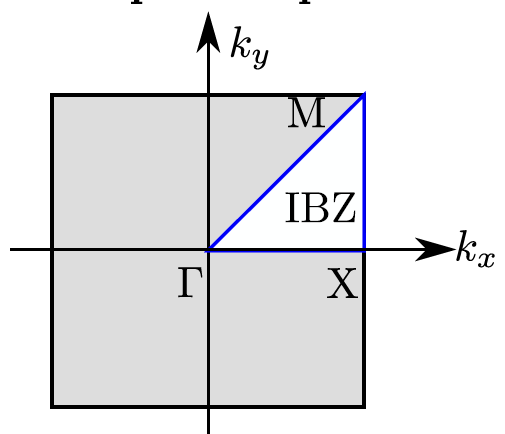

This could be changedby modifying the tuble of high-symmetry points to consider

## Solve on the $\Gamma$-$\rm X$-$\rm M$-$\Gamma$ boundary

The default function is `solve_bands`, and this solves around the IBZ for 4-quad rotational symmetry in the unit cell. If this symmetry is broken, you may need to pass over more high-symmetry points, in which case see the next cell to set up a custom IBZ path with `solve_bands_customHS`

In [23]:
n_wavevector    = 60
n_solutions    = 20
fspace  = 'CG'
evals_disp, evec_all, mpc, KX, KY = solve_bands(n_wavevector  = n_wavevector, 
                        n_solutions = n_solutions, a_len = a_len,
                         c = c,  rho = rho,  fspace = fspace,  
                         mesh = mesh, ct = ct)

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure... 
Computing Γ to X
Computing X to M
Computing M to Γ
Time to compute dispersion 1.727
Band computation complete
-----------------
N_dof....3043
N_vectors....20
N_wavenumbers....60
T total....1.727


# Post-Processing and Visualization

We can collect the summary of the band structure with the `getbands()` command.

To visualize, call the `plotbands()` function from the `PostProcess` module to visual the dispersion curves and band gaps.

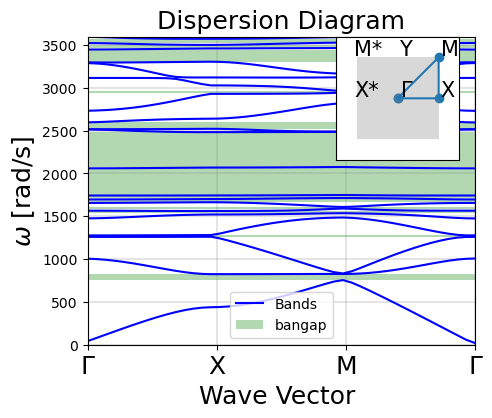

In [24]:
bgnrm, gapwidths, gaps, lowbounds, highbounds = getbands(np.array(evals_disp))
plt = plotbands(bands = np.array(evals_disp), inset = True, KX = KX, KY = KY, a_len= a_len)
plt.show()

# Compute the Dispersion Diagram usin your own High-Symmetry points

Here we show how to define your own IBZ path using the `solve_bands_customHS` function.
We solve on the $\Gamma$-$X$-$M$-$Y$-$\Gamma$ boudnary

In [18]:
# Define the high symmetry points of the lattice
G  = np.array([0,0])                    
X  = np.array([np.pi/a_len, 0])              
M  = np.array([np.pi/a_len, np.pi/a_len])    
Y  = np.array([0, np.pi/a_len] )   
Mp = np.array([-np.pi/a_len, np.pi/a_len])    
Xp = np.array([-np.pi/a_len, 0] )   
HSpts = [G, X, M, Y,
            # G, Y, M,
            # G, Xp, Mp,
            # G, Y, Mp,
            G]

# Define the number of solutiosn per wavevec and number of wavevecs to solve for
n_solutions  = 30
n_wavevector = len(HSpts)*10

# Solve teh eiegensolution. Collect eigenvalues, eigenvectors, constrains, and wavevectors
evals_disp, evec_all, mpc, KX, KY = solve_bands(HSpts  = HSpts, n_wavevector  = n_wavevector,  
                    n_solutions = n_solutions, a_len = a_len,
                        c = c,  rho = rho,  fspace = 'CG',  
                        mesh = mesh, ct = ct)

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure... 
Computing 0.0 to 1.0
Computing 1.0 to 2.0
Computing 2.0 to 3.0
Computing 3.0 to 4.0
Time to compute dispersion 2.617
Band computation complete
-----------------
N_dof....3043
N_vectors....30
N_wavenumbers....50
T total....2.617


## Plotting the disperison over a custom IBZ

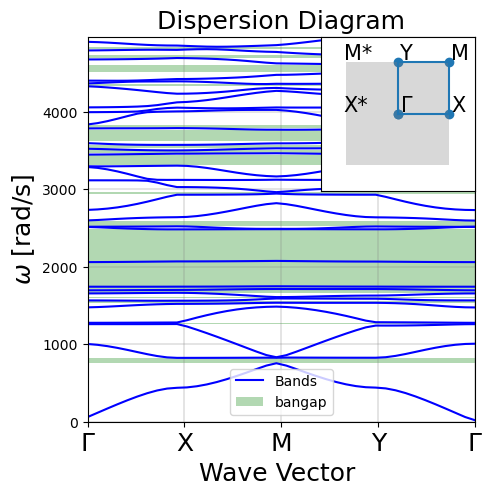

In [19]:
HS_labels = ['$\Gamma$', 'X', 'M', 'Y',
                #  '$\Gamma$', 'Y', 'M',
                #  '$\Gamma$', 'X*', 'M*',
                #  '$\Gamma$', 'Y*', 'M*',
                 '$\Gamma$']
plt = plotbands(np.array(evals_disp),figsize = (5,5), HSpts = HSpts, HS_labels = HS_labels, a_len = a_len,
                      KX = KX, KY = KY, inset = True)
plt.show()

## Plotting the Bloch-eigenmodes


No module named 'trame'

Falling back to a static output.
  warnings.warn(



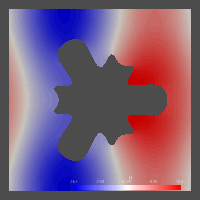

In [15]:
plotter = pyvista.Plotter(shape=(1,1) , window_size=(200,200))
eval_number = 3
evec_number = 0
V = dolfinx.fem.FunctionSpace(mesh,(fspace,1))
plotter = plotvecs(plotter,V,mpc,evec_all,eval_number, evec_number)
plotter.show()


In [ ]:
evec_number = 2
eval_number = 10

plotter = pyvista.Plotter(shape=(5,4) , window_size=(700,700))
for i in range(5):
    for j in range(4):
        plotter.subplot(i,j)  
        plotter = plotvecs(plotter,V,mpc,evec_all, eval_number, evec_number) 
        evec_number += 1
plotter.show()

  mycmap = plt.cm.get_cmap('seismic', 10)




No module named 'trame'

Falling back to a static output.
  warnings.warn(



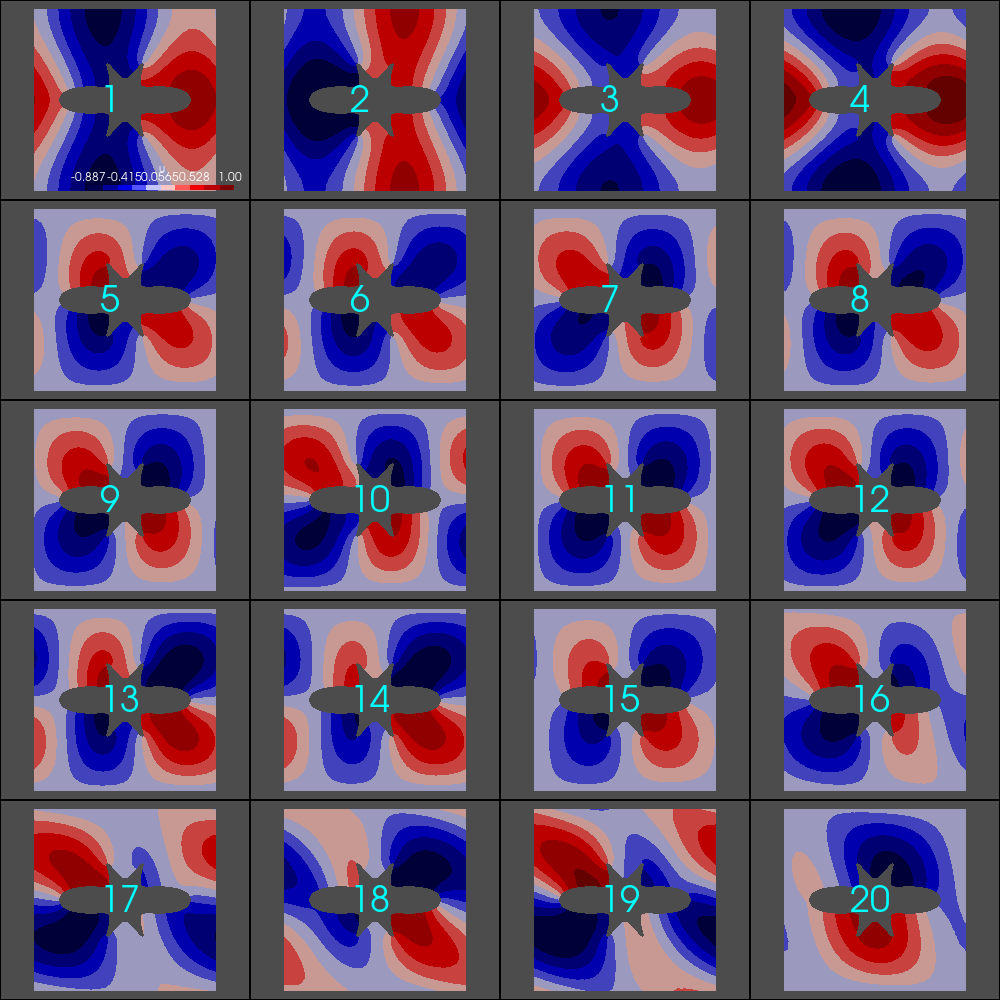

In [24]:
testload = np.array(evec_all) #np.load('data//testFile.npy')
plotter = pyvista.Plotter(shape=(5,4) , window_size=(1000,1000))
###########################################################
# Post-processing the eigenvectors
###########################################################
euse = 0
for i in range(5):
    for j in range(4):
        plotter.subplot(i,j)
        et = testload[euse,:,3]; euse += 1
        vr = Function(V)
        vi = Function(V)
        vr.vector[:] = np.real(et)
        vi.vector[:] = np.imag(et)
        vr.x.scatter_forward()
        mpc.backsubstitution(vr.vector)
        vi.x.scatter_forward()
        mpc.backsubstitution(vi.vector)


        ###########################################################
        # Plotting eigenvectors with pyvista
        ###########################################################
        # mycmap = plt.cm.get_cmap('coolwarm', 10)
        mycmap = plt.cm.get_cmap('seismic', 10)
        u = Function(V)
        cells, types, x = plot.create_vtk_mesh(V)
        grid = pyvista.UnstructuredGrid(cells, types, x)
        grid.point_data["u"] = u.x.array
        u.vector.setArray(vr.vector[:]/np.max(vr.vector[:])*np.sign(vr.vector[10]))
        edges = grid.extract_all_edges()
        warped = grid.warp_by_scalar("u", factor=0)
        plotter.add_mesh(warped, show_edges=False, show_scalar_bar=True, scalars="u",cmap=mycmap)
        # plotter.add_mesh(grid, style = 'wireframe', line_width = .5, color = 'black')
        plotter.view_xy()
        plotter.add_text(str(euse), position=[100,80], color='cyan')
        plotter.camera.tight(padding=0.1)

plotter.show()